# Arab Barometer Survey (2012-14)
### Analyzing Groups with PCA and Agglomerative Clustering

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 60)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

In [51]:
df = pd.read_csv('https://raw.githubusercontent.com/bsmrvl/Unit-1-Build/master/ABIII_English.csv', dtype='str')
print(df.shape)

(14809, 296)


First order of business is to reset the ID column, using the row index instead of the recorded "QID". This is because the dataset also splits records by "Block ID", which results in there being multiple rows for one QID value. To avoid complications with merging dataframes later on, we will use row index as an ID replacement.

In [52]:
df = df.reset_index().drop('qid', axis=1).rename(columns={'index':'id'})
df.head(2)

,id,bid,country,date,wt,form,samp,a1,q1,q13,v13,sex,q101,q102,q102_insh,q102a,q103,q103_insh,q104,q104_insh,q105,q105_insh,q105a,q106,q2011,q2013,q2014,q2016,q2017,q20112,...,q1001,q1002,q1003,q1003t,q1003yem,q1004,q1005,q1006,q1006a,q1007,q1007a,q1009,q1010,q1011,q1011a,q1011b,q1012,q1012a,q1013,q1014,q1015,q1016,q1017,q1019_1,q1019_2,q1020jo,q2001ir,q2003,q2004ir,q2005kw
0,0,1,Algeria,31 Mar 13,.8432402610778809,Form B,Main sample,South,Laghouat,Urban,NaN,Male,Very good,Much better,Yes,Much worse,Most people are not trustworthy,No,"Yes, for economic and political reasons",No,Fully ensured,No,Same as last year,To a limited extent,I trust it to a medium extent,I absolutely do not trust it,I trust it to a medium extent,I trust it to a medium extent,I trust it to a great extent,I trust it to a medium extent,...,40,Male,Prepartory/Basic,NaN,NaN,Yes,NaN,Full time (30 hours or more a week),Private,NaN,Private sector employee,The job does not provide anything at the concl...,Married,Housewife,No,Yes,Muslim,NaN,Owned,19000,38000,Our household income does not cover our expens...,We do not receive anything,Arabic,Amazigh,NaN,NaN,NaN,NaN,NaN
1,1,1,Algeria,31 Mar 13,.6745921969413757,Form A,Main sample,South,Laghouat,Urban,NaN,Female,Good,Somewhat better,Yes,Don't know,Most people are not trustworthy,No,Refuse,No,Not ensured,No,Worse than last year,To a limited extent,I absolutely do not trust it,I absolutely do not trust it,I trust it to a medium extent,I trust it to a great extent,I absolutely do not trust it,I absolutely do not trust it,...,41,Female,Mid-level diploma (professional or technical,NaN,NaN,Yes,NaN,Full time (30 hours or more a week),Public,A governmental employee,NaN,Pension at the conclusion of service,Married,"Professional such as lawyer, accountant, teach...",Yes,Yes,Muslim,NaN,Rented,Refuse,Refuse,Refuse,Refuse,Arabic,Amazigh,NaN,NaN,NaN,NaN,NaN


Since there are so many columns, we will create two much smaller dataframes with our desired features. The first will be demographic features, mostly from Section X in the questionnaire; we will also include features pertaining to participation in the Arab Spring demonstrations.

The second dataframe will contain opinion features in Section VI (social, cultural, and religious) and Section VIII (Arab Spring) of the questionnaire. These are all questions on a 4- or 5-point scale (for example, "Strongly Disagree" to "Strongly Agree"), and we can thus cast them to numeric features and analyze them with PCA. 

### df_personal

In [53]:
df_personal = pd.concat([df[['id', 'country', 'q13']], df.loc[:,'q1001':'q2003']], axis=1)

df_personal = df_personal.rename(columns={'q13':'urb/rur',
                                          'q1001':'age', 
                                          'q1002':'sex', 
                                          'q1004':'work?', 
                                          'q1005':'work_alt', 
                                          'q1006':'full/part',
                                          'q1006a':'sector', 
                                          'q1007':'position_public',
                                          'q1007a':'position_private', 
                                          'q1009':'unemployment',
                                          'q1010':'mar_status', 
                                          'q1011':'spouse_job',
                                          'q1011a':'computer',
                                          'q1011b':'car', 
                                          'q1012':'religion', 
                                          'q1012a':'denomination',
                                          'q1013':'housing',
                                          'q1014':'income', 
                                          'q1015':'household_income', 
                                          'q1016':'income_enough', 
                                          'q1017':'remittances',
                                          'q1019_1':'1st_language', 
                                          'q1019_2':'2nd_language',
                                          'q2003':'appearance'})
df_personal.head(2)

,id,country,urb/rur,age,sex,q1003,q1003t,q1003yem,work?,work_alt,full/part,sector,position_public,position_private,unemployment,mar_status,spouse_job,computer,car,religion,denomination,housing,income,household_income,income_enough,remittances,1st_language,2nd_language,q1020jo,q2001ir,appearance
0,0,Algeria,Urban,40,Male,Prepartory/Basic,NaN,NaN,Yes,NaN,Full time (30 hours or more a week),Private,NaN,Private sector employee,The job does not provide anything at the concl...,Married,Housewife,No,Yes,Muslim,NaN,Owned,19000,38000,Our household income does not cover our expens...,We do not receive anything,Arabic,Amazigh,NaN,NaN,NaN
1,1,Algeria,Urban,41,Female,Mid-level diploma (professional or technical,NaN,NaN,Yes,NaN,Full time (30 hours or more a week),Public,A governmental employee,NaN,Pension at the conclusion of service,Married,"Professional such as lawyer, accountant, teach...",Yes,Yes,Muslim,NaN,Rented,Refuse,Refuse,Refuse,Refuse,Arabic,Amazigh,NaN,NaN,NaN


In [5]:
### We want to combine several occupation columns into one, and do the same thing
### with education. Thus we have to replace NaNs and 'Missing' values with empty
### strings, so that we can add the columns together.

df_personal = df_personal.replace({np.NaN:'', 'Missing':''})

### New occupation column

df_personal['occupation'] = df_personal['work_alt'] + df_personal['position_public'] + df_personal['position_private']
df_personal = df_personal.drop(['work_alt','full/part','sector','position_public','position_private'], axis=1)

### New education column

df_personal['education'] = df_personal['q1003'] + df_personal['q1003t'] + df_personal['q1003yem']
df_personal = df_personal.drop(['q1003','q1003t','q1003yem'], axis=1)

### Drop uninteresting columns or ones with lots of missing values.

df_personal = df_personal.drop(['unemployment','religion','denomination',
                                'income_enough','remittances','1st_language',
                                '2nd_language','q1020jo','q2001ir','appearance'], axis=1)

### Rearrange dataframe

df_personal = df_personal[['id','country','urb/rur','age','sex','education',
                           'work?','occupation','mar_status','spouse_job',
                           'housing','car','computer','income','household_income']]

df_personal.head(2)

,id,country,urb/rur,age,sex,education,work?,occupation,mar_status,spouse_job,housing,car,computer,income,household_income
0,0,Algeria,Urban,40,Male,Prepartory/Basic,Yes,Private sector employee,Married,Housewife,Owned,Yes,No,19000,38000
1,1,Algeria,Urban,41,Female,Mid-level diploma (professional or technical,Yes,A governmental employee,Married,"Professional such as lawyer, accountant, teach...",Rented,Yes,Yes,Refuse,Refuse


In [6]:
df_personal['education'].value_counts()

Secondary                                       3192
Prepartory/Basic                                2831
Elementary                                      2398
ba                                              2363
Illiterate/No formal education                  2148
Mid-level diploma (professional or technical    1439
MA and above                                     247
Mid-level diploma/professional or technical)     101
Pre-high school diploma                           56
Refuse                                            29
                                                   5
Name: education, dtype: int64

In [7]:
### Clearly we need to clean up our combined education column.

df_personal['education'] = df_personal['education'].replace({'Mid-level diploma/professional or technical)':
                                                            'Mid-level diploma (professional or technical',
                                                            'Pre-high school diploma':'Prepartory/Basic',
                                                            'ba':'BA'})
df_personal['education'].value_counts()

Secondary                                       3192
Prepartory/Basic                                2887
Elementary                                      2398
BA                                              2363
Illiterate/No formal education                  2148
Mid-level diploma (professional or technical    1540
MA and above                                     247
Refuse                                            29
                                                   5
Name: education, dtype: int64

In [8]:
### While we're at it let's make a numeric education column called
### 'years_edu'

df_personal.insert(loc=df_personal.columns.get_loc('work?'),
                  column='years_edu',
                  value=df_personal['education'])

df_personal['years_edu'] = df_personal['years_edu'].replace({'Illiterate/No formal education':'0',
                                                            'Elementary':'5',
                                                            'Prepartory/Basic':'8',
                                                            'Secondary':'12',
                                                            'Mid-level diploma (professional or technical':'14',
                                                            'BA':'16',
                                                            'MA and above':'19',
                                                            'Refuse':np.NaN,
                                                            '':np.NaN}).astype('float')

df_personal.head(2)

,id,country,urb/rur,age,sex,education,years_edu,work?,occupation,mar_status,spouse_job,housing,car,computer,income,household_income
0,0,Algeria,Urban,40,Male,Prepartory/Basic,8.0,Yes,Private sector employee,Married,Housewife,Owned,Yes,No,19000,38000
1,1,Algeria,Urban,41,Female,Mid-level diploma (professional or technical,14.0,Yes,A governmental employee,Married,"Professional such as lawyer, accountant, teach...",Rented,Yes,Yes,Refuse,Refuse


In [9]:
### Let's now make sure all missing values are properly denoted as NaNs. 
### Then let's cast age and income features as numeric columns. To make sure
### I make all necessary replacements, here's a look at the current 'income' 
### strings.

print(sorted(df_personal['income'].unique(), reverse=True)[0:6])

['Refuse', 'Not specified', 'No income', "Don't know", '9900', '99']


In [10]:
df_personal = df_personal.replace({'':np.NaN,
                                  'Refuse':np.NaN,
                                  'Not specified':np.NaN,
                                  'Don\'t know':np.NaN,
                                  'No income':'0'})

df_personal[['age','income','household_income']] = df_personal[['age','income','household_income']].astype('float')

df_personal.head(2)

,id,country,urb/rur,age,sex,education,years_edu,work?,occupation,mar_status,spouse_job,housing,car,computer,income,household_income
0,0,Algeria,Urban,40.0,Male,Prepartory/Basic,8.0,Yes,Private sector employee,Married,Housewife,Owned,Yes,No,19000.0,38000.0
1,1,Algeria,Urban,41.0,Female,Mid-level diploma (professional or technical,14.0,Yes,A governmental employee,Married,"Professional such as lawyer, accountant, teach...",Rented,Yes,Yes,NaN,NaN


In [11]:
### Add Arab Spring participation features.

df_personal = pd.concat([df_personal, df.loc[:,'q800a':'q800c']], axis=1).rename(columns={'q800a':
                                                                                         'participate',
                                                                                         'q800b':
                                                                                         'why_par',
                                                                                         'q800c':
                                                                                         'why_not_par'})

df_personal.head(2)

,id,country,urb/rur,age,sex,education,years_edu,work?,occupation,mar_status,spouse_job,housing,car,computer,income,household_income,participate,why_par,why_not_par
0,0,Algeria,Urban,40.0,Male,Prepartory/Basic,8.0,Yes,Private sector employee,Married,Housewife,Owned,Yes,No,19000.0,38000.0,"No, I did not",NaN,I did not care to participate / It was not imp...
1,1,Algeria,Urban,41.0,Female,Mid-level diploma (professional or technical,14.0,Yes,A governmental employee,Married,"Professional such as lawyer, accountant, teach...",Rented,Yes,Yes,NaN,NaN,"No, I did not",NaN,I did not care to participate / It was not imp...


### df_quantitative

In [12]:
df_quant = pd.concat([df['id'], 
                     df.loc[:,'q6012':'q6014'],
                     df.loc[:,'q6041':'q6045'],
                     df.loc[:,'q6051':'q6056'],
                     df.loc[:,'q605b1':'q6087'],
                     df.loc[:,'q6101':'q6106'],
                     df['q810a'],
                     df.loc[:,'q812a1':'q812a8']], axis=1)

df_quant.head(5)

,id,q6012,q6013,q6014,q6041,q6043,q6045,q6051,q6052,q6053,q6054,q6055,q6056,q605b1,q605b2,q6061,q6062,q6063,q6064,q6065,q6066,q6071,q6072,q6073,q6074,q6076,q6082,q6087,q6101,q6105,q6106,q810a,q812a1,q812a2,q812a3,q812a4,q812a5,q812a6,q812a7,q812a8
0,0,I strongly agree,I strongly agree,I somewhat disagree,Constitutes an obstacle to a medium extent,Constitutes an obstacle to a limited extent,Does not constitute an obstacle whatsoever,I strongly agree,I somewhat agree,I somewhat disagree,I strongly agree,I somewhat agree,I strongly agree,I strongly support,I somewhat support,I somewhat agree,I somewhat agree,I somewhat agree,I somewhat agree,I somewhat agree,I strongly agree,I somewhat disagree,I somewhat disagree,I strongly agree,I strongly agree,I strongly agree,I strongly agree,I strongly agree,Always,Always,Most of the time,More of personal loss,Somewhat important,Somewhat important,Somewhat important,Somewhat important,Very important,Very important,Very important,Very important
1,1,I somewhat disagree,I strongly agree,I somewhat disagree,Constitutes an obstacle to a limited extent,Constitutes an obstacle to a limited extent,Constitutes an obstacle to a limited extent,I strongly agree,I strongly agree,I strongly agree,I strongly agree,I strongly agree,I strongly agree,I strongly support,I strongly support,Don't know,Don't know,Don't know,Don't know,Don't know,Don't know,Don't know,I somewhat agree,I somewhat agree,I somewhat agree,I somewhat agree,Don't know,Don't know,Always,Most of the time,Sometimes,More of personal loss,Very important,Very important,Very important,Very important,Not that important,Not that important,Very important,Very important
2,2,I somewhat agree,I somewhat agree,I strongly disagree,Constitutes an obstacle to a great extent,Constitutes an obstacle to a limited extent,Constitutes an obstacle to a limited extent,I somewhat disagree,I somewhat agree,I somewhat agree,I somewhat disagree,I somewhat agree,I somewhat agree,I strongly support,Don't know,I somewhat agree,I somewhat disagree,I somewhat disagree,I somewhat agree,I somewhat agree,I somewhat agree,I somewhat disagree,I somewhat disagree,I somewhat disagree,I somewhat disagree,I somewhat disagree,Don't know,Don't know,Refuse,Refuse,Refuse,More of personal loss,Somewhat important,Somewhat important,Somewhat important,Somewhat important,Not important at all,Not important at all,Very important,Very important
3,3,I strongly agree,I somewhat agree,I strongly disagree,Constitutes an obstacle to a medium extent,Constitutes an obstacle to a medium extent,Constitutes an obstacle to a medium extent,I strongly agree,I somewhat agree,I somewhat agree,I somewhat agree,I somewhat agree,I strongly agree,I strongly support,Don't know,I somewhat agree,Don't know,I strongly agree,I strongly agree,I strongly agree,I strongly agree,Don't know,I somewhat agree,I strongly agree,I strongly agree,I somewhat disagree,I strongly agree,I strongly agree,Always,Rarely,Sometimes,More of personal victory,Somewhat important,Somewhat important,Somewhat important,Somewhat important,Very important,Very important,Very important,Very important
4,4,I somewhat disagree,I strongly agree,I somewhat agree,Constitutes an obstacle to a medium extent,Constitutes an obstacle to a medium extent,Does not constitute an obstacle whatsoever,Don't know,I strongly agree,I somewhat agree,I somewhat agree,I somewhat agree,I somewhat agree,I somewhat support,I do not support,I somewhat agree,I strongly disagree,I strongly disagree,I strongly agree,I somewhat agree,I somewhat agree,I somewhat disagree,I somewhat disagree,I somewhat agree,I somewhat agree,I strongly agree,I somewhat agree,I somewhat agree,Always,Always,Most of the time,More of personal victory,Not that important,Not that important,Somewhat important,Not important at all,Not that important,Refuse,Somewhat important,Somewhat important


In [13]:
df_quant = df_quant.replace({'I strongly disagree':'-2',
                            'I somewhat disagree':'-1',
                            'I somewhat agree':'1',
                            'I strongly agree':'2',
                            'Does not constitute an obstacle whatsoever':'-2',
                            'Constitutes an obstacle to a limited extent':'-1',
                            'Constitutes an obstacle to a medium extent':'1',
                            'Constitutes an obstacle to a great extent':'2',
                            'I strongly do not support':'-2',
                            'I do not support':'-1',
                            'I somewhat support':'1',
                            'I strongly support':'2',
                            'Never':'-2',
                            'Rarely':'-1',
                            'Sometimes':'0',
                            'Most of the time':'1',
                            'Always':'2',
                            'No':'-1',
                            'Yes':'1',
                            'More of personal loss':'-1',
                            'Difficult to define':'0',
                            'More of personal victory':'1',
                            'Not important at all':'-2',
                            'Not that important':'-1',
                            'Somewhat important':'1',
                            'Very important':'2',
                            'Don\'t know':np.NaN,
                            'Refuse':np.NaN,
                            'Missing':np.NaN})

df_quant.head(10)

,id,q6012,q6013,q6014,q6041,q6043,q6045,q6051,q6052,q6053,q6054,q6055,q6056,q605b1,q605b2,q6061,q6062,q6063,q6064,q6065,q6066,q6071,q6072,q6073,q6074,q6076,q6082,q6087,q6101,q6105,q6106,q810a,q812a1,q812a2,q812a3,q812a4,q812a5,q812a6,q812a7,q812a8
0,0,2,2,-1,1,-1,-2,2,1,-1,2,1,2,2,1,1,1,1,1,1,2,-1,-1,2,2,2,2,2,2,2,1,-1,1,1,1,1,2,2,2,2
1,1,-1,2,-1,-1,-1,-1,2,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,NaN,NaN,2,1,0,-1,2,2,2,2,-1,-1,2,2
2,2,1,1,-2,2,-1,-1,-1,1,1,-1,1,1,2,NaN,1,-1,-1,1,1,1,-1,-1,-1,-1,-1,NaN,NaN,NaN,NaN,NaN,-1,1,1,1,1,-2,-2,2,2
3,3,2,1,-2,1,1,1,2,1,1,1,1,2,2,NaN,1,NaN,2,2,2,2,NaN,1,2,2,-1,2,2,2,-1,0,1,1,1,1,1,2,2,2,2
4,4,-1,2,1,1,1,-2,NaN,2,1,1,1,1,1,-1,1,-2,-2,2,1,1,-1,-1,1,1,2,1,1,2,2,1,1,-1,-1,1,-2,-1,NaN,1,1
5,5,2,2,-1,2,-2,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,0,-1,1,1,1,1,-1,-1,1,1
6,6,2,2,-2,-1,-1,-1,-1,-1,1,-1,1,1,2,2,2,-2,-2,2,2,2,-1,-1,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,1,1,1,1,2,2
7,7,1,2,-1,1,-2,-2,-2,1,-2,1,2,2,1,1,-1,1,1,-1,-1,-1,2,NaN,2,NaN,-2,2,NaN,2,2,1,NaN,-1,1,2,1,2,2,-1,-1
8,8,1,2,-1,-1,1,1,1,1,2,-1,2,1,2,-1,2,-1,1,2,1,2,-2,-2,-1,1,2,1,1,0,1,0,0,1,-1,1,2,1,2,2,2
9,9,1,1,-1,-1,1,1,NaN,NaN,1,1,1,1,2,1,1,NaN,2,NaN,1,1,-1,2,1,1,2,-2,1,2,-1,-1,0,2,-1,1,1,2,2,2,2


In [14]:
### We see below that we lose a good bit of data by dropping NaNs. But
### 8000 instances is not bad at all.

print(df_quant.shape)
print(df_quant.dropna().shape)

(14809, 40)
(8139, 40)


In [15]:
df_quant = df_quant.dropna().astype('int')
print(df_quant.shape)
df_quant.head()

(8139, 40)


,id,q6012,q6013,q6014,q6041,q6043,q6045,q6051,q6052,q6053,q6054,q6055,q6056,q605b1,q605b2,q6061,q6062,q6063,q6064,q6065,q6066,q6071,q6072,q6073,q6074,q6076,q6082,q6087,q6101,q6105,q6106,q810a,q812a1,q812a2,q812a3,q812a4,q812a5,q812a6,q812a7,q812a8
0,0,2,2,-1,1,-1,-2,2,1,-1,2,1,2,2,1,1,1,1,1,1,2,-1,-1,2,2,2,2,2,2,2,1,-1,1,1,1,1,2,2,2,2
8,8,1,2,-1,-1,1,1,1,1,2,-1,2,1,2,-1,2,-1,1,2,1,2,-2,-2,-1,1,2,1,1,0,1,0,0,1,-1,1,2,1,2,2,2
16,16,1,2,-2,1,2,2,1,1,1,1,1,1,2,2,-1,2,2,-1,-1,1,1,2,2,-1,-1,2,-2,2,2,1,0,1,-1,2,1,1,1,1,1
17,17,2,-2,-2,-2,2,2,-1,1,1,1,1,1,2,-1,2,-2,-2,2,2,2,-1,-1,1,2,2,1,1,-1,-1,-1,0,1,1,1,1,1,1,1,1
30,30,1,-1,1,2,1,1,1,-1,1,-1,-2,-1,1,-1,-2,-1,-2,-1,1,-1,1,-1,1,-1,-2,1,-1,2,1,0,0,1,-1,1,-1,1,-1,2,1


### PCA on df_quant

In [16]:
scaler = StandardScaler()

df_Z = scaler.fit_transform(df_quant.drop('id', axis=1))

pca = PCA()

pca.fit(df_Z)

comp = pca.transform(df_Z)

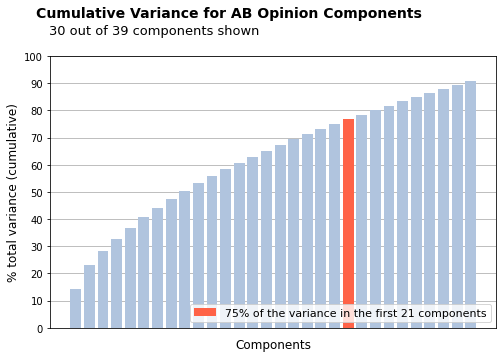

In [17]:
### Scree plot

cum_variance_percent = np.cumsum(pca.explained_variance_ratio_)*100

fig, ax = plt.subplots(figsize=[8,5])

fig.set_facecolor('white')

ax.set_xlabel('Components', fontsize=12, labelpad=10)
ax.set_xticks([])
ax.set_ylabel('% total variance (cumulative)', fontsize=12)
ax.set_ylim([0,100])
ax.set_yticks([t*10 for t in range(11)])

show = 30
percent_thresh = 75


# Main bars
rects = ax.bar(x=[num for num in range(show)], height=cum_variance_percent[:show], color='lightsteelblue', zorder=100)

# Function to determine the point at which the threshold is passed
def percent_of_variance(rects, percent):
  for i in range(len(rects)):
    if rects[i].get_height() > percent:
      return i

# Run function and print tomato bar.
first = percent_of_variance(rects, percent_thresh)
thresh = ax.bar(x=first, height=cum_variance_percent[first], color='tomato', zorder=200)

ax.set_title('Cumulative Variance for AB Opinion Components', fontsize=14, fontweight='bold', x=.4, y=1.12)
ax.text(s=str(show) + ' out of 39 components shown', x=-2, y=108, fontsize=13)

ax.grid(b=True, axis='y')
ax.legend([thresh],[str(percent_thresh) + '% of the variance in the first ' + str(first+1) + ' components'], loc='lower right', fontsize=11).set_zorder(300)

plt.show()

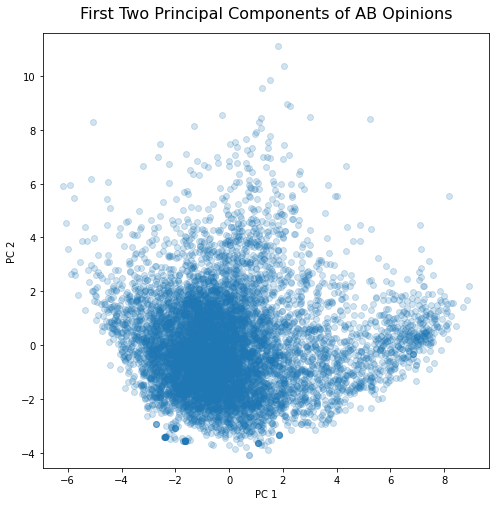

In [18]:
### The first 2 components only hold about 23% of the variance, but let's
### take a look at them anyway!

fig, ax = plt.subplots(figsize=[8,8])
ax.axis('equal')

ax.scatter(comp[:,0], comp[:,1], alpha=.2)

ax.set_title('First Two Principal Components of AB Opinions', fontsize=16, y=1.02)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')

plt.show()

Two things struck me seeing this plot. The first was the roundness, sort of like a mixing bowl being jostled. I had the idea to eyeball a center of the bowls arc, and add two new features to df_personal, radius and angle from this center. This will become more clear below.

I then noticed the oven mitt shape, or maybe a sideways thumbs up. This was clearly something to investigate via clustering. However, k-means clustering failed me, and I won't waste space in this tidy notebook demonstrating that. I researched other clustering algorithms and decided to try 'agglomerative'. I don't know how it works, but it worked much better for my purposes.

### Clustering

In [19]:
n = 2

glom = AgglomerativeClustering(n_clusters=n)
glom.fit(comp[:,0:21])

AgglomerativeClustering()

Size of cluster 1 : (7080, 3)
Size of cluster 2 : (1059, 3)


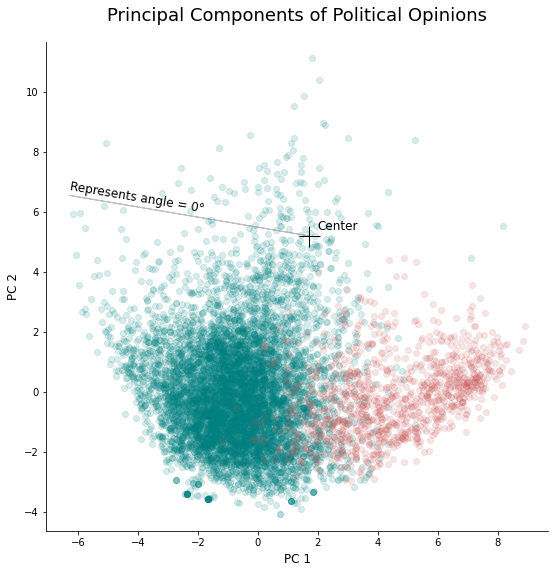

In [47]:
df_clusters = pd.DataFrame({'pc1':comp[:,0], 'pc2':comp[:,1], 'clus':glom.labels_}, index=df_quant['id'])

by_cluster = []

for c in range(n):
    by_cluster.append(df_clusters[df_clusters['clus'] == c])

fig, ax = plt.subplots(figsize=[9,9])
ax.axis('equal')
fig.set_facecolor('white')

colors = ['teal', 'indianred']

center = np.array([1.7,5.2])
zero_theta = np.array([-8,1.35])
    
ax.arrow(center[0], center[1], zero_theta[0], zero_theta[1], color='grey', alpha=.5)
ax.text(s='Center', x=2, y=5.4, fontsize=12)

ax.plot(center[0], center[1], marker='+', markersize=21, color='black')
ax.text(s='Represents angle = 0°', x=-6.3, y=6, rotation=-9.5, fontsize=12)

for c in range(n):
    ax.scatter(by_cluster[c]['pc1'], by_cluster[c]['pc2'], alpha=.15, color=colors[c])
    print('Size of cluster', c+1, ':', by_cluster[c].shape)

ax.set_title('Principal Components of Political Opinions', fontsize=18, y=1.03)
ax.set_xlabel('PC 1', labelpad=5, fontsize=12)
ax.set_ylabel('PC 2', fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('mixingbowl.png', dpi=300, format='png')
plt.show()

Note that despite the plot only looking at PC1 and PC2, I used 21 principal components when agglomerating the clusters. I had no strong case for picking this number, except that it looked nice. Also the scree plot above shows that 75% of variance is included in these first 21.

We can now merge our clusters dataframe with df_personal, and calculate the radius and angle metrics mentioned above. The center point marked on the plot above is what we will measure radius from, and the line is what we will measure angle against.

In [21]:
df_clusters = df_clusters.reset_index()
df_clusters.head()

,id,pc1,pc2,clus
0,0,-0.273071,-1.425033,0
1,8,1.592004,-0.662571,0
2,16,-3.529339,2.597325,0
3,17,3.439426,0.110564,1
4,30,1.217626,4.602077,0


In [22]:
df_ana = df_clusters.merge(df_personal, how='inner', on='id')
print(df_ana.shape)
df_ana.head(3)

(8139, 22)


,id,pc1,pc2,clus,country,urb/rur,age,sex,education,years_edu,work?,occupation,mar_status,spouse_job,housing,car,computer,income,household_income,participate,why_par,why_not_par
0,0,-0.273071,-1.425033,0,Algeria,Urban,40.0,Male,Prepartory/Basic,8.0,Yes,Private sector employee,Married,Housewife,Owned,Yes,No,19000.0,38000.0,"No, I did not",NaN,I did not care to participate / It was not imp...
1,8,1.592004,-0.662571,0,Algeria,Urban,28.0,Male,Elementary,5.0,Yes,Private sector employee,Bachelor,NaN,Other,No,Yes,17000.0,17000.0,"Yes, I did",Because everyone was participating in these de...,NaN
2,16,-3.529339,2.597325,0,Algeria,Urban,22.0,Male,Prepartory/Basic,8.0,No,Unemployed,Bachelor,NaN,Owned,No,Yes,NaN,NaN,"No, I did not",NaN,I did not care to participate / It was not imp...


In [23]:
### Add radius column

radii = []

for index, row in df_ana.iterrows():
    point = np.array([row['pc1'], row['pc2']])
    radii.append(np.linalg.norm(center - point))
    
df_ana.insert(loc=df_ana.columns.get_loc('country'),
              column='radius',
              value=radii)

df_ana.head(3)

,id,pc1,pc2,clus,radius,country,urb/rur,age,sex,education,years_edu,work?,occupation,mar_status,spouse_job,housing,car,computer,income,household_income,participate,why_par,why_not_par
0,0,-0.273071,-1.425033,0,6.912602,Algeria,Urban,40.0,Male,Prepartory/Basic,8.0,Yes,Private sector employee,Married,Housewife,Owned,Yes,No,19000.0,38000.0,"No, I did not",NaN,I did not care to participate / It was not imp...
1,8,1.592004,-0.662571,0,5.863566,Algeria,Urban,28.0,Male,Elementary,5.0,Yes,Private sector employee,Bachelor,NaN,Other,No,Yes,17000.0,17000.0,"Yes, I did",Because everyone was participating in these de...,NaN
2,16,-3.529339,2.597325,0,5.841224,Algeria,Urban,22.0,Male,Prepartory/Basic,8.0,No,Unemployed,Bachelor,NaN,Owned,No,Yes,NaN,NaN,"No, I did not",NaN,I did not care to participate / It was not imp...


In [24]:
### Function for calculating angle

def calc_angle(x, y, against=zero_theta):
    point = np.array([x,y]) - center
    return np.arccos(np.dot(point, against)/(np.linalg.norm(point)*np.linalg.norm(against)))

In [25]:
### Add angle column

angles = []

for index, row in df_ana.iterrows():
    angles.append(calc_angle(row['pc1'], row['pc2']))
    
df_ana.insert(loc=df_ana.columns.get_loc('country'),
              column='angle',
              value=angles)

df_ana.head(3)

,id,pc1,pc2,clus,radius,angle,country,urb/rur,age,sex,education,years_edu,work?,occupation,mar_status,spouse_job,housing,car,computer,income,household_income,participate,why_par,why_not_par
0,0,-0.273071,-1.425033,0,6.912602,1.448515,Algeria,Urban,40.0,Male,Prepartory/Basic,8.0,Yes,Private sector employee,Married,Housewife,Owned,Yes,No,19000.0,38000.0,"No, I did not",NaN,I did not care to participate / It was not imp...
1,8,1.592004,-0.662571,0,5.863566,1.719552,Algeria,Urban,28.0,Male,Elementary,5.0,Yes,Private sector employee,Bachelor,NaN,Other,No,Yes,17000.0,17000.0,"Yes, I did",Because everyone was participating in these de...,NaN
2,16,-3.529339,2.597325,0,5.841224,0.628986,Algeria,Urban,22.0,Male,Prepartory/Basic,8.0,No,Unemployed,Bachelor,NaN,Owned,No,Yes,NaN,NaN,"No, I did not",NaN,I did not care to participate / It was not imp...


In [26]:
### Rearrange columns again to separate numeric and categorical. 

move_to_end = ['age','years_edu','income','household_income','pc1','pc2','clus','radius','angle']

df_ana = df_ana[[col for col in df_ana if col not in move_to_end] + move_to_end]
df_ana.head(3)

,id,country,urb/rur,sex,education,work?,occupation,mar_status,spouse_job,housing,car,computer,participate,why_par,why_not_par,age,years_edu,income,household_income,pc1,pc2,clus,radius,angle
0,0,Algeria,Urban,Male,Prepartory/Basic,Yes,Private sector employee,Married,Housewife,Owned,Yes,No,"No, I did not",NaN,I did not care to participate / It was not imp...,40.0,8.0,19000.0,38000.0,-0.273071,-1.425033,0,6.912602,1.448515
1,8,Algeria,Urban,Male,Elementary,Yes,Private sector employee,Bachelor,NaN,Other,No,Yes,"Yes, I did",Because everyone was participating in these de...,NaN,28.0,5.0,17000.0,17000.0,1.592004,-0.662571,0,5.863566,1.719552
2,16,Algeria,Urban,Male,Prepartory/Basic,No,Unemployed,Bachelor,NaN,Owned,No,Yes,"No, I did not",NaN,I did not care to participate / It was not imp...,22.0,8.0,NaN,NaN,-3.529339,2.597325,0,5.841224,0.628986


In [27]:
### One more thing--let's change 'education' into an ordered
### categorical.

df_ana['education'] = pd.Categorical(df_ana['education'], categories=['Illiterate/No formal education',
                                                                      'Elementary',
                                                                      'Prepartory/Basic',
                                                                      'Secondary',
                                                                      'Mid-level diploma (professional or technical',
                                                                      'BA',
                                                                      'MA and above'], ordered=True)

### Analysis / Plots

Now I'm going to run a whole lot of chi-2 contingency tests to check for relationships between the categorical features and the cluster number. I'm going to do the same thing with the radius and angle features, binning them and then comparing to all categorical features.

In [28]:
features = df_ana.loc[:,'country':'why_not_par'].columns
p_cluster = []
p_radius = []
p_angle = []

for feat in features:
    p_cluster.append(stats.chi2_contingency(pd.crosstab(df_ana['clus'], df_ana[feat]))[1])
    p_radius.append(stats.chi2_contingency(pd.crosstab(pd.cut(df_ana['radius'], bins=4), df_ana[feat]))[1])
    p_angle.append(stats.chi2_contingency(pd.crosstab(pd.cut(df_ana['angle'], bins=4), df_ana[feat]))[1])
    
df_chi = pd.DataFrame({'feat':features, 
                       'p_cluster':p_cluster,
                       'p_radius':p_radius,
                       'p_angle':p_angle})
df_chi

,feat,p_cluster,p_radius,p_angle
0,country,0.000000e+00,6.119120e-82,0.000000e+00
1,urb/rur,9.999120e-25,3.155980e-05,9.452338e-31
2,sex,7.813774e-02,4.056760e-02,3.342828e-04
3,education,1.501029e-21,1.541867e-23,1.956234e-16
4,work?,6.995728e-06,5.742492e-06,4.707178e-10
5,occupation,4.602682e-47,4.634530e-08,2.296222e-60
6,mar_status,9.215106e-11,1.104881e-05,7.167985e-18
7,spouse_job,9.315011e-12,1.335066e-01,6.622582e-14
8,housing,9.331044e-04,5.391601e-01,5.530404e-05
9,car,3.271767e-14,1.299377e-01,9.473617e-20


A few things to note right off the bat. First, most of these p-values are very low. Even at a 99% confidence level we would reject the null (that there is no relationship) in almost every case. However, that's not particularly interesting to me. Most of the relationships here, though existent, are very weak. The results may be **significant**, but they are not interesting.

Fortunately that is not the case for all of them! In the plots below we look at some of the relationships with the lowest p-values, and find the results to be quite fascinating.

The other thing to note is that p-values against cluster and p-values against angle seem similar. This makes perfect sense looking at the cluster plot above, which shows the blue and orange clusters to be split at a little over 90 degrees. However, as we will see below, the two are not redundant. Let's look at that first.

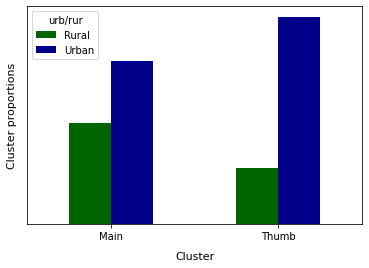

In [29]:
### Here's the proportions of urban and rural people in each cluster. Both
### are mostly urban, but clearly the thumb cluster (orange in the scatter plot)
### is far more so. 

colors = ['darkgreen','darkblue']

pd.crosstab(df_ana['clus'], df_ana['urb/rur'], normalize='index').plot(kind='bar', color=colors)

plt.xticks([0,1], labels=['Main', 'Thumb'], rotation=0)
plt.xlabel('Cluster', fontsize=11, labelpad=10)
plt.yticks([])
plt.ylabel('Cluster proportions', fontsize=11, labelpad=10)
plt.show()

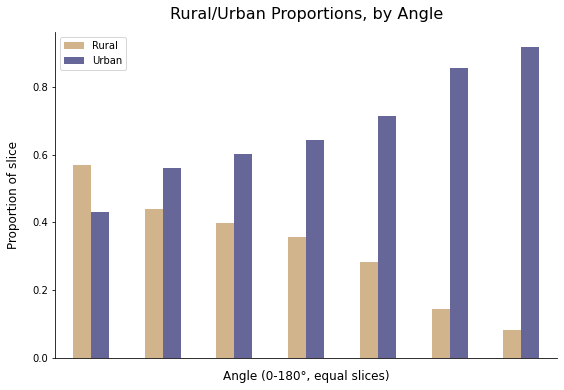

In [30]:
### Looking at the same plot, but against angle rather than cluster, we
### might expect the same binomial split. However this is not the case. 
### Despite angle being a very abstract feature, urbanity increases quite
### steadily with increasing angle.

colors = ['tan', '#666699']

pd.crosstab(pd.cut(df_ana['angle'], bins=7), df_ana['urb/rur'], normalize='index').plot(figsize=[9,6],
                                                                                       color=colors,
                                                                                       kind='bar')

plt.title('Rural/Urban Proportions, by Angle', fontsize=16, y=1.02)

plt.xticks([])
plt.xlabel('Angle (0-180°, equal slices)', fontsize=12, labelpad=12)
# plt.yticks([])
plt.ylabel('Proportion of slice', fontsize=12, labelpad=12)
plt.legend(['Rural','Urban'])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gcf().set_facecolor('white')

plt.savefig('rururb.png', dpi=300, format='png')
plt.show()

---

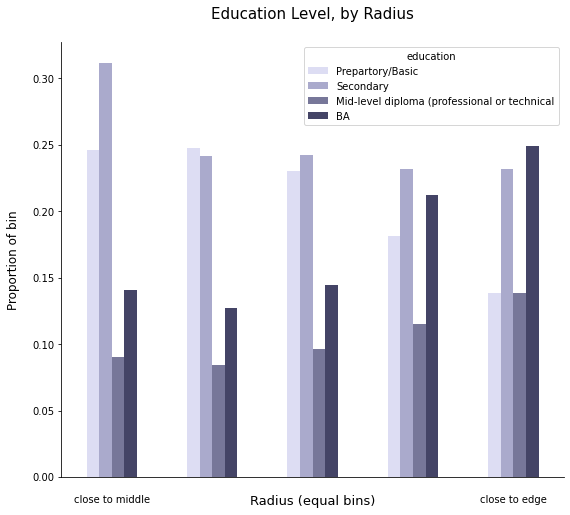

In [50]:
### Next, we can see in the p-value table that education is most strongly
### related to our radius feature. I tried a few different plots and found
### that the outer education levels (illerate, elementary, and MA) only
### added noise. In calculating the proportions of education levels at
### different radius strata, I retained these outer levels, but dropped
### them while plotting.

ct = pd.crosstab(pd.cut(df_ana['radius'], bins=5), df_ana['education'], normalize='index')

colors = ['#ddddf3', '#aaaacc', '#777799', '#444466']

ct.drop(['Illiterate/No formal education',
         'Elementary',
         'MA and above'], axis=1).plot(figsize=[9,8], color=colors, linewidth=2, kind='bar')

plt.title('Education Level, by Radius', fontsize=15, y=1.04)

plt.xticks([0,1,2,3,4], ['close to middle','','','','close to edge'], rotation=0)
plt.xlabel('Radius (equal bins)', fontsize=13, labelpad=-10)
plt.ylabel('Proportion of bin', fontsize=12, labelpad=12)
plt.tick_params(axis='x', length=14, color='white')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gcf().set_facecolor('white')

plt.savefig('educate.png', dpi=300, format='png')
plt.show()

In [32]:
### The trends are pretty clear. The higher two education levels increase with
### radius, while the lower two decrease, or stay roughly the same.

---

In [33]:
### Occupation seems to be strongly related to both cluster and angle. For
### simplicity's sake let's plot its relation to cluster.

ct2 = pd.crosstab(df_ana['occupation'], df_ana['clus'], normalize='columns')
ct2['ratio'] = ct2[0] / ct2[1]
ct2 = ct2.sort_values(by='ratio', ascending=False)

ct2

clus,0,1,ratio
occupation,,,
Other,0.006578,0.000961,6.847683
Working at the armed forces or the police,0.029966,0.011527,2.599583
Director of an institution or a high ranking governmental employee,0.017541,0.008646,2.028943
Employer/director of an institution with 10 employees or more,0.007455,0.003842,1.940177
A governmental employee,0.185207,0.104707,1.768810
A student,0.100570,0.059558,1.688604
Unemployed,0.131998,0.097983,1.347159
A housewife,0.233884,0.213256,1.096726
Agricultural worker/Owner of a farm,0.015641,0.016330,0.957781


In [34]:
ct2 = ct2.rename(index={'Working at the armed forces or the police':'Armed forces / police',
                       'Director of an institution or a high ranking governmental employee':'Director of institution or high ranking governmental',
                       'Employer/director of an institution with 10 employees or more':'Director of an institution, >=10 employees',
                       'A governmental employee':'Governmental employee',
                       'A student':'Student',
                       'A housewife':'Housewife',
                       'Agricultural worker/Owner of a farm':'Farm owner/worker',
                       'Professional such as lawyer, accountant, teacher, doctor, etc.':'Professional (lawyer, accountant, teacher, doctor, etc.)',
                       'Employer/director of an institution with less than 10 employees':'Director of an institution, <10 employees',
                       'Owner of a shop/grocery store':'Shop/grocery store owner'})

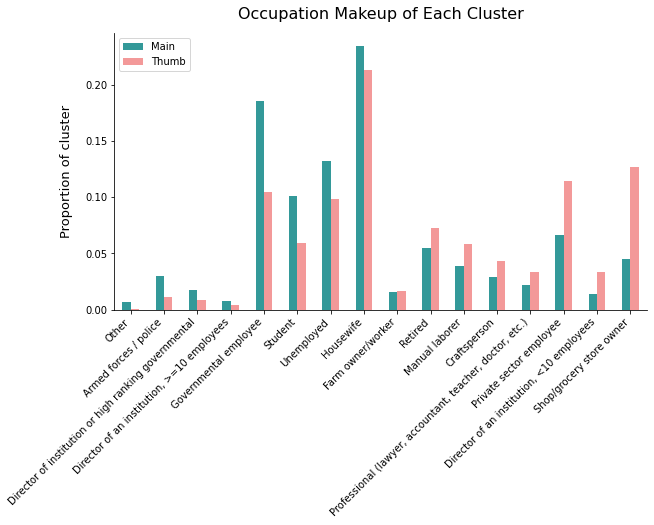

In [35]:
colors = ['teal', 'lightcoral']

ct2.drop('ratio', axis=1).plot(kind='bar', figsize=[10,8], color=colors, alpha=.8)

plt.title('Occupation Makeup of Each Cluster', fontsize=16, y=1.03)

plt.xticks(rotation=45, ha='right')
plt.xlabel('')
# plt.yticks([])
plt.ylabel('Proportion of cluster', fontsize=13, labelpad=12)
plt.legend(labels=['Main','Thumb'], loc='upper left')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gcf().set_facecolor('white')
plt.gcf().subplots_adjust(left=.16, bottom=0.4)

plt.savefig('occupate.png', dpi=300, format='png')
plt.show()

In [36]:
print('Occupations proportionally more common in *main* cluster\n')
for occ in ct2[ct2['ratio'] > 1.25].index:
    print(occ)
    
print('\n\nNeutral occupations\n')
for occ in ct2[(ct2['ratio'] > .8) & (ct2['ratio'] < 1.25)].index:
    print(occ)
    
print('\n\nOccupations proportionally more common in *thumb* cluster\n')
for occ in ct2[ct2['ratio'] < .8].index:
    print(occ)

Occupations proportionally more common in *main* cluster

Other
Armed forces / police
Director of institution or high ranking governmental
Director of an institution, >=10 employees
Governmental employee
Student
Unemployed


Neutral occupations

Housewife
Farm owner/worker


Occupations proportionally more common in *thumb* cluster

Retired
Manual laborer
Craftsperson
Professional (lawyer, accountant, teacher, doctor, etc.)
Private sector employee
Director of an institution, <10 employees
Shop/grocery store owner


### Correlation 

I'll now add my quantitative dataframe and calculate correlations for Radius and Angle, with all those 4-5 point questions which we used for PCA. 

NOTE we have to be careful making conclusions here. Since the component parameters are calculated from these original numeric features, it's wrong for us to say we can "predict" these features from radius or angle on the PCA plot, no matter how strong the correlations. That would be a roundabout way of saying "Because you answered 'strongly agree' on this question we are quite certain you answered 'strongly agree'."

The point here is not to predict, but to get an intuition for what our PCA components actually mean. That way when we plot the categorical features based on abstract PCA parameters, we can begin to understand the actual human significance.

In [37]:
df_ana = df_ana.merge(df_quant, on='id')
df_ana.shape

(8139, 63)

In [38]:
df_ana.head(3)

,id,country,urb/rur,sex,education,work?,occupation,mar_status,spouse_job,housing,car,computer,participate,why_par,why_not_par,age,years_edu,income,household_income,pc1,pc2,clus,radius,angle,q6012,q6013,q6014,q6041,q6043,q6045,...,q6054,q6055,q6056,q605b1,q605b2,q6061,q6062,q6063,q6064,q6065,q6066,q6071,q6072,q6073,q6074,q6076,q6082,q6087,q6101,q6105,q6106,q810a,q812a1,q812a2,q812a3,q812a4,q812a5,q812a6,q812a7,q812a8
0,0,Algeria,Urban,Male,Prepartory/Basic,Yes,Private sector employee,Married,Housewife,Owned,Yes,No,"No, I did not",NaN,I did not care to participate / It was not imp...,40.0,8.0,19000.0,38000.0,-0.273071,-1.425033,0,6.912602,1.448515,2,2,-1,1,-1,-2,...,2,1,2,2,1,1,1,1,1,1,2,-1,-1,2,2,2,2,2,2,2,1,-1,1,1,1,1,2,2,2,2
1,8,Algeria,Urban,Male,Elementary,Yes,Private sector employee,Bachelor,NaN,Other,No,Yes,"Yes, I did",Because everyone was participating in these de...,NaN,28.0,5.0,17000.0,17000.0,1.592004,-0.662571,0,5.863566,1.719552,1,2,-1,-1,1,1,...,-1,2,1,2,-1,2,-1,1,2,1,2,-2,-2,-1,1,2,1,1,0,1,0,0,1,-1,1,2,1,2,2,2
2,16,Algeria,Urban,Male,Prepartory/Basic,No,Unemployed,Bachelor,NaN,Owned,No,Yes,"No, I did not",NaN,I did not care to participate / It was not imp...,22.0,8.0,NaN,NaN,-3.529339,2.597325,0,5.841224,0.628986,1,2,-2,1,2,2,...,1,1,1,2,2,-1,2,2,-1,-1,1,1,2,2,-1,-1,2,-2,2,2,1,0,1,-1,2,1,1,1,1,1


#### Radius Correlations

In [39]:
radius_corr = df_ana.loc[:,'radius':'q812a8'].corr()[['radius']].drop('angle')
radius_corr.head()

,radius
radius,1.000000
q6012,0.172284
q6013,0.054639
q6014,-0.203452
q6041,0.141034


In [40]:
radius_corr = radius_corr.rename(columns={'radius':'corr'})
radius_corr['square'] = radius_corr['corr']**2
radius_corr = radius_corr.sort_values(by='square', ascending=False)
radius_corr.head(10)

,corr,square
radius,1.000000,1.000000
q812a8,0.545328,0.297383
q812a7,0.541022,0.292704
q812a4,0.443657,0.196832
q812a5,0.394581,0.155694
q812a2,0.358391,0.128444
q605b1,0.337230,0.113724
q6056,0.329760,0.108742
q812a6,0.327973,0.107566
q6066,0.324520,0.105313


The top five correlations above all correspond to subsets of question q812a, which is:

> *As you may know, Egypt, Tunisia, Yemen, and Libya are currently in the phase of drafting new constitutions. Considering your own country’s constitution, what is the importance of the constitution in … ?*

The choices most correlated with radius are, in order:

- *Guaranteeing social protection and health insurance for the poor*
- *Guaranteeing workers’ rights*
- *Insuring the separation between the legislative and executive authorities*
- *Keeping politics beyond the army*
- *Insuring equal rights between Muslims and non-Muslims*

As radius increases, these roles of the new constitution become more important.

#### Angle Correlations

In [41]:
angle_corr = df_ana.loc[:,'angle':'q812a8'].corr()[['angle']]
angle_corr.head()

,angle
angle,1.000000
q6012,0.271245
q6013,-0.341150
q6014,-0.291619
q6041,-0.431436


In [42]:
angle_corr = angle_corr.rename(columns={'angle':'corr'})
angle_corr['square'] = angle_corr['corr']**2
angle_corr = angle_corr.sort_values(by='square', ascending=False)
angle_corr.head(10)

,corr,square
angle,1.000000,1.000000
q6054,-0.627045,0.393185
q6052,-0.623201,0.388380
q6055,-0.566420,0.320831
q605b2,-0.554736,0.307733
q6062,-0.545988,0.298103
q812a3,-0.530470,0.281398
q6056,-0.505135,0.255162
q6063,-0.490307,0.240401
q6064,0.485245,0.235462


Here the top three correlations correspond to q605:

> *To what extent do you agree or disagree with each of the following principles in the enactment of your country’s laws and regulations?*

The choices most correlated are:
- *The government and parliament should enact penal laws in accordance with Islamic law*
- *The government and parliament should enact laws in accordance with Islamic law.*
- *The government and parliament should enact personal status laws (marriage, divorce) in accordance with Islamic law*

NOTE that these correlations are negative! That means as angle increases (toward the thumb cluster), people **disagree** more with these statements.